In [93]:
import importlib
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/workspaces/.gcp/waffleml_dev_key.json"

if not "model" in sys.modules:
    model = importlib.import_module("model", package=".")
    helpers = importlib.import_module("wml_helpers")
else:
    model = importlib.reload(model)
    pass

print(os.getcwd())

/workspaces/f33-gcp-mlops/examples/kaggle_store_item_demand_forecasting/models/xgb_ar


In [94]:
def download_prediction(phase="perf", fold_idx=0, output_file="predictions"):
    if fold_idx == 0:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--0--rnd--wdal/prediction_8236172773077024768/predictions", output_file)
        return pd.read_csv(output_file)
    if fold_idx == 1:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--1--rnd--trka/prediction_969614774314729472/predictions", output_file)
        return pd.read_csv(output_file)
    if fold_idx == 2:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--2--rnd--akxc/prediction_8722561532833038336/predictions", output_file)
        return pd.read_csv(output_file)

def download_ground_truth(phase="perf", fold_idx=0, output_file="test"):
    if fold_idx == 0:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--0--rnd--wdal/get-data_3624486754649636864/dataset_ground_truth", output_file)
        return pd.read_csv(output_file)
    if fold_idx == 1:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--1--rnd--trka/get-data_8463604554259234816/dataset_ground_truth", output_file)
        return pd.read_csv(output_file)
    if fold_idx == 2:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--2--rnd--akxc/get-data_4110875514405650432/dataset_ground_truth", output_file)
        # helpers.get_file_from_bucket("gs://f33-mlops/11582800304/tomorrow-is-today--perf--2--rnd--fuqz/get-data_-8198207736081547264/dataset_ground_truth", output_file)
        return pd.read_csv(output_file)

def download_train(phase="perf", fold_idx=0, output_file="train"):
    if fold_idx == 0:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--0--rnd--wdal/get-data_3624486754649636864/dataset_train", output_file)
        return pd.read_csv(output_file)
    if fold_idx == 1:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--1--rnd--trka/get-data_8463604554259234816/dataset_train", output_file)
        return pd.read_csv(output_file)
    if fold_idx == 2:
        helpers.get_file_from_bucket("gs://f33-mlops/11582800304/xgb-ar--perf--2--rnd--akxc/get-data_4110875514405650432/dataset_train", output_file)
        return pd.read_csv(output_file)

In [95]:
preds = [download_prediction(phase="perf", fold_idx=i, output_file=f"predictions-perf-{i}.csv") for i in range(3)]

In [96]:
pred = pd.concat(preds[::-1], axis=0).to_numpy()[:, 1]
# pred = preds[0].to_numpy()[: ,1]

In [97]:
tests = [download_ground_truth(phase="perf", fold_idx=i, output_file=f"test-perf-{i}.csv") for i in range(3)]

In [98]:
test = pd.concat(tests[::-1], axis=0).sort_values(by=["store", "item", "date"])
# test = tests[0].sort_values(by=["store", "item", "date"])

In [99]:
trains = [download_train(phase="perf", fold_idx=i, output_file=f"train-perf-{i}.csv")  for i in range(3)]
train = trains[0]

In [100]:
pred

array([17.302883, 49.64511 , 27.20878 , ..., 58.30679 , 30.546461,
       74.84563 ])

In [101]:
test["sales"]

0      15
0      27
0      23
10     50
10     56
       ..
489    40
489    42
499    74
499    62
499    82
Name: sales, Length: 1500, dtype: int64

In [102]:
test["prediction"] = pred
test["ae"] = np.abs(test["sales"] - test["prediction"])
test["ape"] = test["ae"]/test["sales"]
test["e"] = test["sales"] - test["prediction"]

In [103]:
test

,Unnamed: 0,date,store,item,sales,prediction,ae,ape,e
0,0,2017-12-29,1,1,15,17.302883,2.302883,0.153526,-2.302883
0,0,2017-12-30,1,1,27,49.645110,22.645110,0.838708,-22.645110
0,0,2017-12-31,1,1,23,27.208780,4.208780,0.182990,-4.208780
10,10,2017-12-29,1,2,50,17.272703,32.727297,0.654546,32.727297
10,10,2017-12-30,1,2,56,15.983516,40.016484,0.714580,40.016484
...,...,...,...,...,...,...,...,...,...
489,489,2017-12-30,10,49,40,65.371500,25.371500,0.634287,-25.371500
489,489,2017-12-31,10,49,42,23.168169,18.831831,0.448377,18.831831
499,499,2017-12-29,10,50,74,58.306790,15.693210,0.212070,15.693210
499,499,2017-12-30,10,50,62,30.546461,31.453539,0.507315,31.453539


In [105]:
(test
    .groupby(by="store")
    .mean(numeric_only=True)
    .sort_values("ae")
)

,Unnamed: 0,item,sales,prediction,ae,ape,e
store,,,,,,,
6,250.0,25.5,37.486667,44.435088,23.403618,0.926426,-6.948422
5,249.0,25.5,37.800000,49.013821,24.029951,0.969958,-11.213821
7,251.0,25.5,34.940000,51.378329,24.840586,1.228963,-16.438329
1,245.0,25.5,45.386667,51.587545,25.420610,0.763473,-6.200878
9,253.0,25.5,52.613333,38.604662,26.207672,0.572216,14.008671
4,248.0,25.5,52.940000,53.513792,27.551583,0.682422,-0.573792
10,254.0,25.5,55.786667,60.153659,28.938380,0.725962,-4.366992
3,247.0,25.5,57.446667,46.507039,29.406714,0.571613,10.939627
8,252.0,25.5,61.580000,61.109572,30.589019,0.658897,0.470428


In [104]:
(train
    .groupby(by="store")
    .mean(numeric_only=True)
)

,Unnamed: 0,item,sales
store,,,
1,448037.0,25.5,47.268110
2,449862.0,25.5,67.032964
3,451687.0,25.5,59.529403
4,453512.0,25.5,54.901863
5,455337.0,25.5,39.770323
6,457162.0,25.5,39.733271
7,458987.0,25.5,36.363595
8,460812.0,25.5,64.142071
9,462637.0,25.5,55.048789


In [106]:
test_store = test[test["store"] == 5]
test_store

,Unnamed: 0,date,store,item,sales,prediction,ae,ape,e
4,4,2017-12-29,5,1,18,23.080763,5.080763,0.282265,-5.080763
4,4,2017-12-30,5,1,19,67.122665,48.122665,2.532772,-48.122665
4,4,2017-12-31,5,1,24,40.970990,16.970990,0.707125,-16.970990
14,14,2017-12-29,5,2,42,22.789177,19.210823,0.457401,19.210823
14,14,2017-12-30,5,2,28,21.403421,6.596579,0.235592,6.596579
...,...,...,...,...,...,...,...,...,...
484,484,2017-12-30,5,49,16,45.800037,29.800037,1.862502,-29.800037
484,484,2017-12-31,5,49,21,15.606286,5.393714,0.256844,5.393714
494,494,2017-12-29,5,50,37,40.290905,3.290905,0.088943,-3.290905
494,494,2017-12-30,5,50,60,21.148249,38.851751,0.647529,38.851751


In [107]:
(test_store
    .groupby(by="item")
    .mean(numeric_only=True)
    .sort_values("ae", ascending=False)
)

,Unnamed: 0,store,sales,prediction,ae,ape,e
item,,,,,,,
5,44.0,5.0,13.666667,81.352475,67.685808,4.950884,-67.685808
4,34.0,5.0,13.666667,74.118346,60.451680,4.454376,-60.451680
21,204.0,5.0,25.333333,75.894293,50.560959,2.071104,-50.560959
27,264.0,5.0,15.000000,55.078213,40.078213,2.837646,-40.078213
23,224.0,5.0,14.333333,52.945201,38.611868,2.960281,-38.611868
3,24.0,5.0,30.333333,67.021393,36.688059,1.250630,-36.688059
32,314.0,5.0,34.000000,57.723604,33.553774,1.066923,-23.723604
20,194.0,5.0,31.333333,64.140619,32.807285,1.126300,-32.807285
28,274.0,5.0,76.000000,44.969307,31.030693,0.409613,31.030693


In [108]:
test_store_item = test_store[test_store["item"] == 37]
test_store_item

,Unnamed: 0,date,store,item,sales,prediction,ae,ape,e
364,364,2017-12-29,5,37,23,34.220123,11.220123,0.487831,-11.220123
364,364,2017-12-30,5,37,31,51.474460,20.474460,0.660466,-20.474460
364,364,2017-12-31,5,37,11,52.092686,41.092686,3.735699,-41.092686


In [109]:
p = pd.concat([preds[1], tests[1]], axis=1)
p = p[(p["store"] == 5) & (p["item"] == 37)]
p

,Unnamed: 0,prediction,Unnamed: 0,date,store,item,sales
364,2919,101.4218,364,2017-12-30,5,37,31


<AxesSubplot: xlabel='date'>

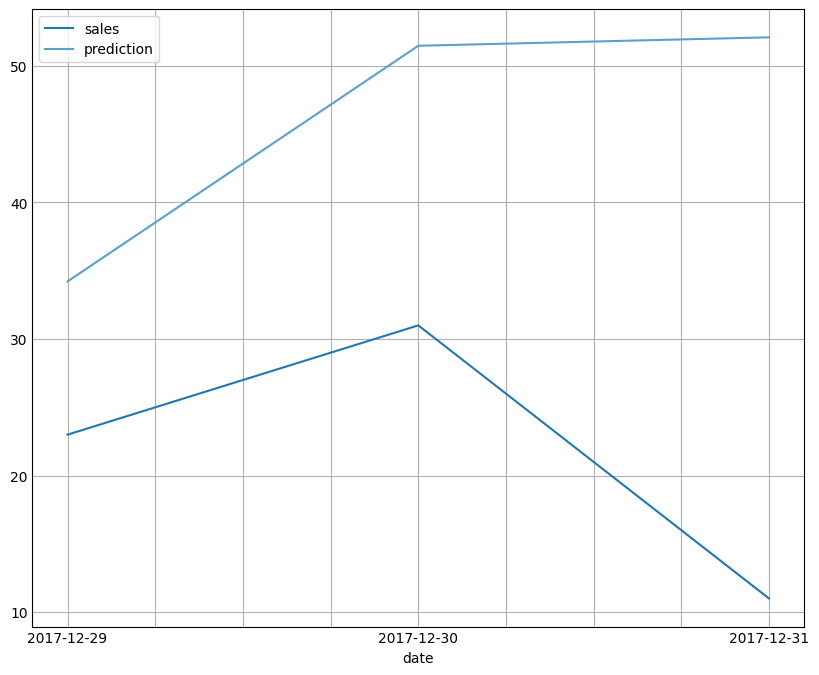

In [110]:
test_store_item.plot(x="date", y=["sales", "prediction"])

In [111]:
train_store_item = train[(train["store"] == 5) & (train["item"] == 37) ]
train_store_item = train_store_item[ train_store_item["date"] >= "2013-12-01"]
train_store_item

,Unnamed: 0,date,store,item,sales
664634,664634,2013-12-01,5,37,11
664635,664635,2013-12-02,5,37,7
664636,664636,2013-12-03,5,37,12
664637,664637,2013-12-04,5,37,12
664638,664638,2013-12-05,5,37,14
...,...,...,...,...,...
666120,666120,2017-12-26,5,37,10
666121,666121,2017-12-27,5,37,20
666122,666122,2017-12-28,5,37,15
666123,666123,2017-12-29,5,37,23


<AxesSubplot: xlabel='date'>

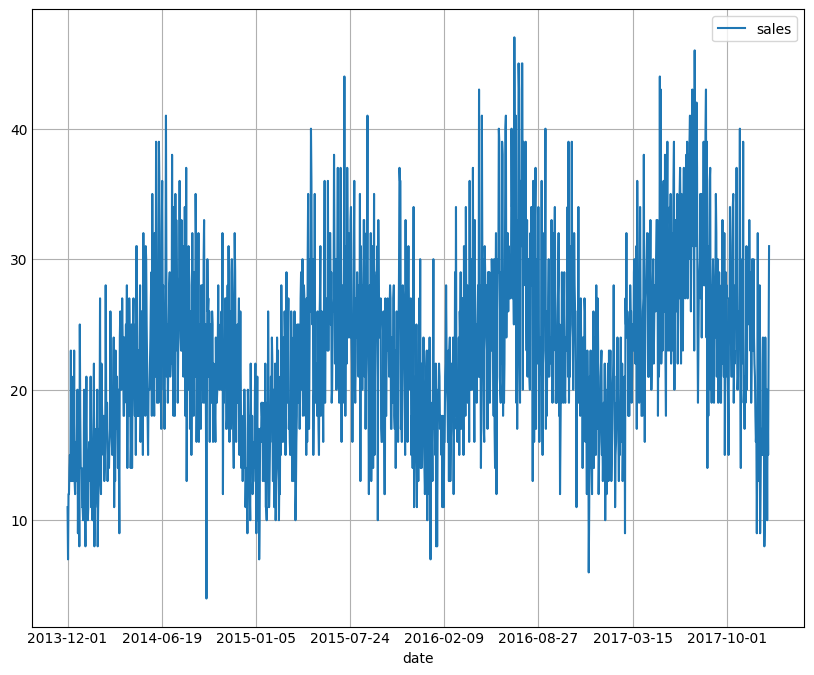

In [112]:
train_store_item.plot(x="date", y="sales")